### Understanding the Limitations of LSTMs in Predicting Random Sums of Sines

This notebook explores the performance of **Long Short-Term Memory (LSTM)** models in predicting functions that are composed of random sums of sine waves. These functions are designed to simulate the characteristics of **emotion data**, which typically exhibit complex, irregular, and oscillatory behavior.

The objective is to generate synthetic data that mimics the behavior of emotion patterns over time, using a linear combination of sine functions with added noise, including Brownian motion. This setup aims to test the predictive capabilities and limitations of LSTM models, as well as to compare them against simpler models like **weighted averages** and **fully connected neural networks**.

#### The analysis includes:
1. **Synthetic Data Generation:**  
   - Randomly generated sine functions with Gaussian-distributed amplitudes, frequencies, and uniform-distributed phase shifts, plus added Brownian motion noise.
2. **Model Training and Evaluation:**  
   - Models tested include weighted average models, single-step LSTMs, and multistep LSTMs. Performance is evaluated on both training and testing data.
   - Recursive prediction techniques are applied to analyze the models' robustness in handling longer-term forecasting.
3. **Results Analysis:**  
   - The notebook visualizes training and validation loss curves and compares predicted signals with the true signals on both training and testing samples.
   - The outcomes help understand the capacity and limitations of LSTMs in capturing complex, irregular time-series patterns.

This notebook serves as a foundational analysis for predicting emotion patterns using time-series models, focusing on identifying where LSTMs excel and where they struggle. Insights from this study can inform further improvements in **AI alignment tasks** that aim to predict human emotional responses more accurately.


In [6]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/Users/arnav/Google Drive/Cornell/Coding Projects/emili_TimeSeriesPredictor') #going up several files until emili_TimeSeriesPredictor
from time_series_predictor.Data.emotionFeatureExtractor import emotionFeatureExtractor
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

#importing models
from time_series_predictor.Models.lstm_models import LSTMUnivariateRecursivePred, LSTMUnivariateMultiStep
from time_series_predictor.Models.weighted_average import WeightedAverageModel, MultiStepFullyConnectedNN
from time_series_predictor.Models.train_predict import train, predict, recursive_predict, calculate_mse_loss

### **Generating Synthetic Data**

**Parameters**

In [7]:
# Set random seed for reproducibility
np.random.seed(42)

# Sine function parameters
'''

'''

#Function parameters
nSines = 5 #Number of sines in the linear combination
amplitude_dist = (0, 1)  # Mean, Std for normal distribution
frequency_dist = (0, 1)  # Mean, Std for normal distribution
phase_dist = (0, 2 * np.pi)  # Min, Max for uniform distribution


#Supervise learning parameters
lookback = 1500
forecast = 300
timesteps = 1500+300 #each spaced delta_t apart
delta_t = 0.01 # time between samples
assert timesteps == lookback + forecast

nFunctions = 1000
noise_lvl = 0

print(f'Time between each sample is {delta_t}')
print(f'Number of seconds per function is {delta_t*(lookback+forecast)}')


Time between each sample is 0.01
Number of seconds per function is 18.0


**Generating Univariate Random Sine Functions**

$f_n(x) = \sum_{i=1}^k{A_{in}\sin({B_{in}x+C_{in}}})+\sigma*W_n(x)$
- $x = $ 0, 0.01, 0.02, ... timesteps-1/100 (x = time in seconds)
- $A_{in} $~$ N(0,1)$
- $B_{in} $~$ N(0,1)$
- $C_{in} $~$ Unif(0,2*\pi)$
- $W_n(x)$ = geometric brownian motion. $W_n(x) = \sum_{j=1}^x{\hat{Z_j}}$ --todo mean reverting 
- $\hat{Z_j}$ ~ $N(0,\sigma^2)$ i.i.d

(1000, 1800, 1)


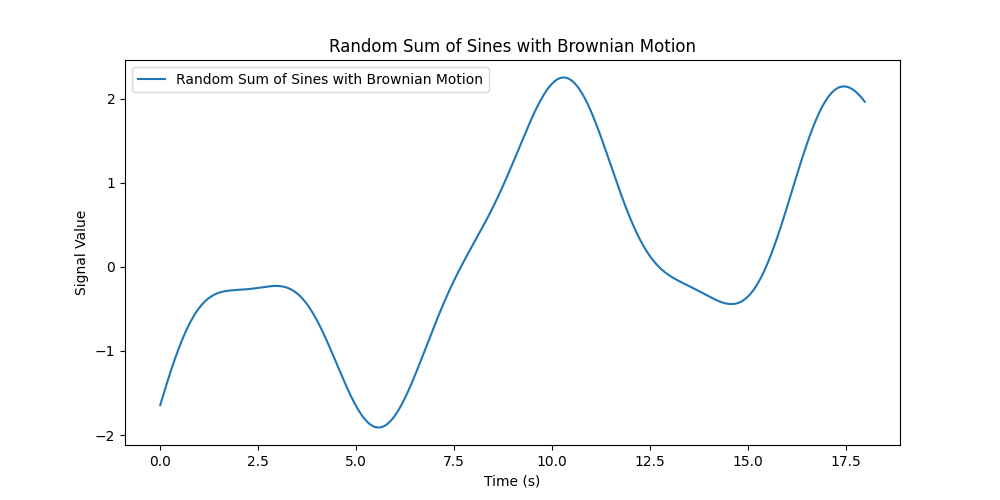

In [8]:
def generate_random_sines(n, k_sines, timesteps, delta_t, amplitude_dist, frequency_dist, phase_dist, noise_lvl = 0.01):
    """
    Generates n of random linear combinations of k_sines sine functions with added Brownian motion.

    Parameters:
    - n (int): Number of different functions to generate.
    - k_sines (int): Number of sine functions to combine in each sample.
    - timesteps (int): Total number of time steps in each sine wave.
    - delta_t (float): Time step interval.
    - amplitude_dist (tuple): Distribution parameters for amplitude (mean, std).
    - frequency_dist (tuple): Distribution parameters for frequency (mean, std).
    - phase_dist (tuple): Distribution parameters for phase shift (min, max).
    - noise_lvl (float): Size of GBM noise to add

    Returns:
    - t (numpy.ndarray): Array of timestamps for each value with shape (timesteps); each function has the same time start and end
    - data (numpy.ndarray): Array of generated sine waves with shape (n, timesteps).
    """
    data = []

    for _ in range(n): #creating n functions
        # Generate time array
        t = np.linspace(0, (timesteps - 1) * delta_t, timesteps)
        
        # Initialize signal as zero to sum over multiple sine components
        signal = np.zeros(timesteps)
        
        for _ in range(k_sines):
            # Generate random parameters for a single sine wave
            amplitude = np.random.normal(*amplitude_dist)
            frequency = np.random.normal(*frequency_dist)
            phase_shift = np.random.uniform(*phase_dist)

            # Add the sine component to the signal
            signal += amplitude * np.sin(frequency * t + phase_shift)

        # Add Brownian motion noise
        # Using additive noise here instead of exponential scaling
        brownian_motion = np.cumsum(np.random.normal(0, delta_t, timesteps))
        signal += noise_lvl*brownian_motion
        
        # Store the generated signal with Brownian noise
        data.append(signal)

    return t, np.array(data)

t, data = generate_random_sines(n=nFunctions, 
                                   k_sines=nSines, timesteps=timesteps,
                                   delta_t=delta_t, 
                                   amplitude_dist=amplitude_dist, frequency_dist=frequency_dist, phase_dist=phase_dist,
                                   noise_lvl=noise_lvl)

#Convert so that data is in shape (nSamples,timesteps,features)
data = data[:,:,np.newaxis]
print(data.shape)

# Visualize one of the generated sine waves with Brownian noise
plt.close('all')
fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(timesteps) * delta_t, data[0], label='Random Sum of Sines with Brownian Motion')
plt.xlabel("Time (s)")
plt.ylabel("Signal Value")
plt.title("Random Sum of Sines with Brownian Motion")
plt.legend()
plt.show()


**Train Test Split**

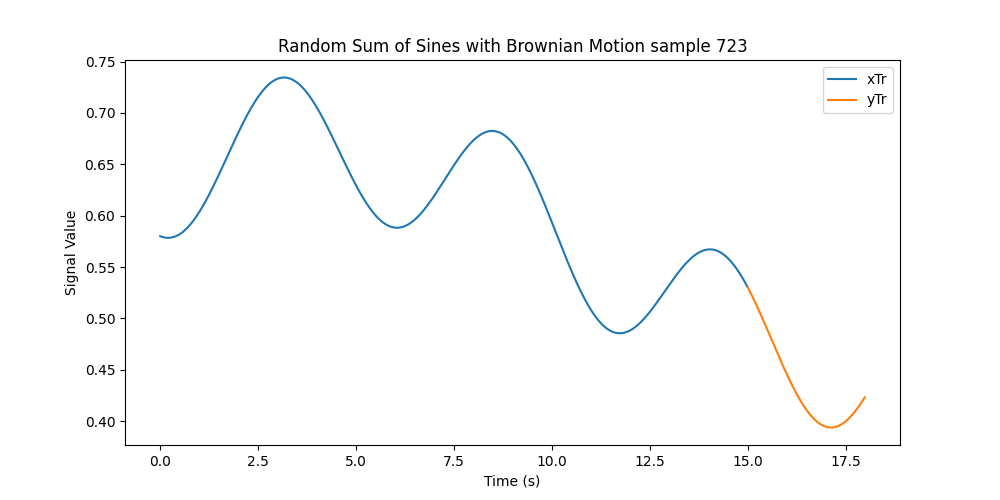

In [9]:
def train_test_split(data, lookback_period, forecast_period, split = 0.2):
    #rescaling:
    data_min = data.min(axis=(0, 1), keepdims=True)  # shape: (1, 1, features)
    data_max = data.max(axis=(0, 1), keepdims=True)  # shape: (1, 1, features)

    # Apply Min-Max Scaling
    data = (data - data_min) / (data_max - data_min)

    nTr = int(data.shape[0]*(1-split)) # number of training samples
    xTr = data[:nTr,:lookback_period]
    yTr = data[:nTr,lookback_period:]
    xTe = data[nTr:,:lookback_period]
    yTe = data[nTr:,lookback_period:]

    return xTr, yTr, xTe, yTe

xTr,yTr,xTe,yTe = train_test_split(data=data,lookback_period=lookback,forecast_period=forecast,split = 0.2)

# # Check the split is correct:
random_sample = np.random.randint(0,xTr.shape[0])

plt.figure(figsize=(10, 5))
plt.plot(np.arange(lookback) * delta_t, xTr[random_sample], label='xTr')
plt.plot(np.arange(lookback,timesteps) * delta_t, yTr[random_sample], label='yTr')
plt.xlabel("Time (s)")
plt.ylabel("Signal Value")
plt.title(f"Random Sum of Sines with Brownian Motion sample {random_sample}")
plt.legend()
plt.show()

# Training and Predicting

In [10]:
lookback = xTr.shape[1]
features = xTr.shape[2]

weighted_average_model = WeightedAverageModel(timesteps=lookback, features=features)
lstm_model = LSTMUnivariateRecursivePred(timesteps=lookback, features=features, lstm_units=64, recursive_forecast_length=1)
# lstm_model_recursive_train = LSTMUnivariateRecursivePred(timesteps=lookback, features=features, lstm_units=64, recursive_forecast_length=forecast)
lstm_multistep = LSTMUnivariateMultiStep(timesteps=lookback, features=features, lstm_units=64, forecast_length=forecast)
multistepNN = MultiStepFullyConnectedNN(timesteps=lookback, features=features, hidden_units=64, forecast_length=forecast)

# Train the Weighted Average Model and capture the loss history
print("Training the Weighted Average Model...")
weighted_average_train_loss, weighted_average_val_loss, weighted_average_nSample_loss = train(
    model=weighted_average_model,
    xTrain=xTr,
    yTrain=yTr[:,0:1,:],  # !! only predict the next point
    xVal=xTe,  # Validation data
    yVal=yTe[:,0:1,:],  # Validation labels
    epochs=1,          
    batch_size=1,      
    lr=0.001,
    shuffle=False        
)

# Train the LSTM Model and capture the loss history
print("Training the LSTM Model...")
lstm_train_loss, lstm_val_loss, lstm_nSample_loss = train(
    model=lstm_model,
    xTrain=xTr,
    yTrain=yTr[:,0:1,:],  # !! only predict the next point
    xVal=xTe,  # Validation data
    yVal=yTe[:,0:1,:],  # Validation labels
    epochs=1,          
    batch_size=1,      
    lr=0.001,
    shuffle=False          
)

print("Training the Multistep LSTM Model...")
lstm_multistep_train_loss, lstm_multistep_val_loss, lstm_multistep_nSample_loss = train(
    model=lstm_multistep,
    xTrain=xTr,
    yTrain=yTr,  
    xVal=xTe,  # Validation data
    yVal=yTe,  # Validation labels
    epochs=1,          
    batch_size=1,      
    lr=0.001,
    shuffle=False          
)

print("Training the Multistep NN Model...")
multistepNN_train_loss, multistepNN_val_loss, multistepNN_nSample_loss = train(
    model=multistepNN,
    xTrain=xTr,
    yTrain=yTr,
    xVal=xTe,  # Validation data
    yVal=yTe,
    epochs=1,          
    batch_size=1,      
    lr=0.001,
    shuffle=False        
)

Training the Weighted Average Model...
Epoch 1/1, Training Loss: 0.0112, Validation Loss: 0.0091
Training the LSTM Model...
Epoch 1/1, Training Loss: 0.0035, Validation Loss: 0.0001
Training the Multistep LSTM Model...
Epoch 1/1, Training Loss: 0.0172, Validation Loss: 0.0111
Training the Multistep NN Model...
Epoch 1/1, Training Loss: 0.0195, Validation Loss: 0.0133


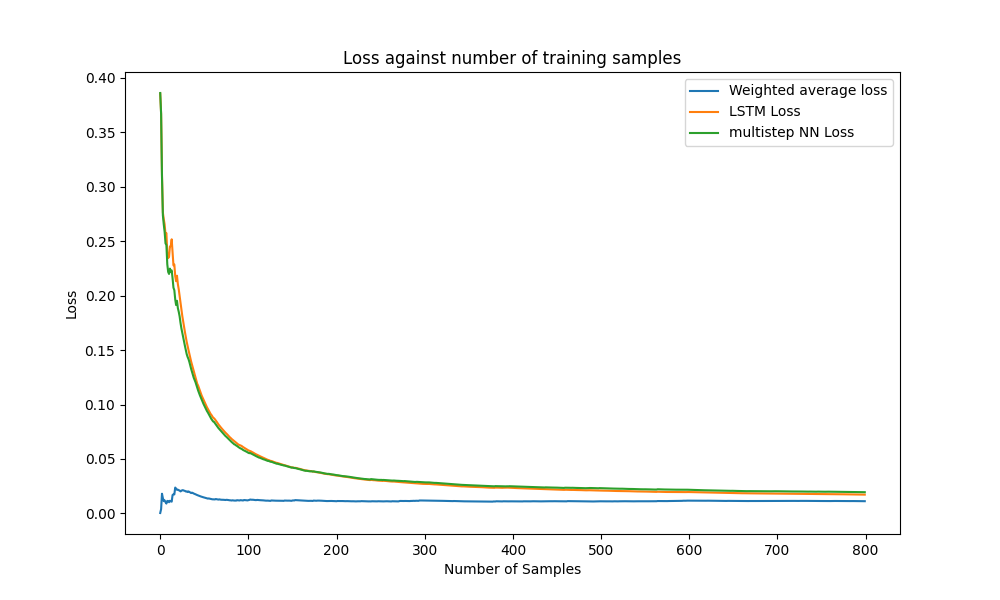

In [11]:
#Plotting loss over number of samples
plt.figure(figsize=(10, 6))

# Weighted Average Model loss curves
plt.plot(weighted_average_nSample_loss, label='Weighted average loss')

plt.plot(lstm_multistep_nSample_loss, label='LSTM Loss ')

plt.plot(multistepNN_nSample_loss, label='multistep NN Loss ')

plt.title("Loss against number of training samples")

plt.xlabel("Number of Samples")
plt.ylabel("Loss")
plt.legend()
plt.show()

*Note that the weighted average loss is not useful since it is the loss for only predicting the next timestep, not the whole forecast period. This is a bug I am working on fixing

**Training and Validation Loss Curves**


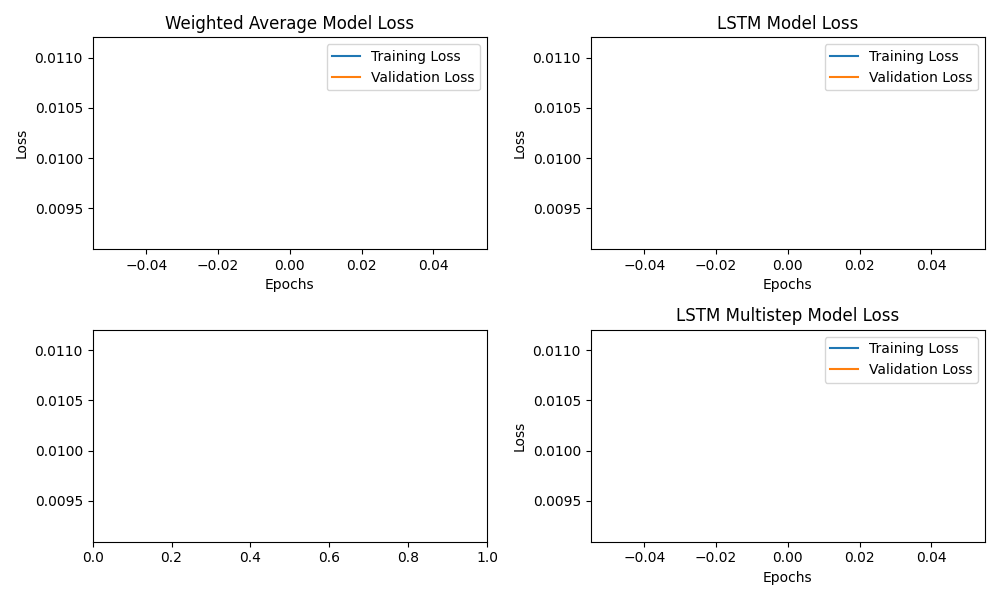

In [12]:
# Plot training and validation loss curves for the Weighted Average Model
plt.figure(figsize=(10, 6))

# Weighted Average Model loss curves
plt.subplot(2, 2, 1)
plt.plot(weighted_average_train_loss, label='Training Loss')
plt.plot(weighted_average_val_loss, label='Validation Loss')
plt.title("Weighted Average Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# LSTM Model loss curves
plt.subplot(2, 2, 2)
plt.plot(lstm_train_loss, label='Training Loss')
plt.plot(lstm_val_loss, label='Validation Loss')
plt.title("LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# LSTM recursive Model loss curves
# plt.subplot(2, 2, 3)
# plt.plot(lstm_recursive_train_loss, label='Training Loss')
# plt.plot(lstm_recursive_val_loss, label='Validation Loss')
# plt.title("Recursive Prediction Trained LSTM Model Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()

plt.subplot(2, 2, 4)
plt.plot(lstm_multistep_train_loss, label='Training Loss')
plt.plot(lstm_multistep_val_loss, label='Validation Loss')
plt.title("LSTM Multistep Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set the same y-axis limits for both plots
y_min = min(min(weighted_average_train_loss), min(weighted_average_val_loss))#,
            # min(lstm_train_loss), min(lstm_val_loss))
y_max = max(max(weighted_average_train_loss), max(weighted_average_val_loss))#,
            # max(lstm_train_loss), max(lstm_val_loss))

plt.subplot(2, 2, 1)
plt.ylim([y_min,y_max])  # Set y-axis limits for the first plot

plt.subplot(2, 2, 2)
plt.ylim([y_min,y_max])  # Set y-axis limits for the second plot

plt.subplot(2, 2, 3)
plt.ylim([y_min,y_max])  # Set y-axis limits for the second plot

plt.subplot(2, 2, 4)
plt.ylim([y_min,y_max])  # Set y-axis limits for the second plot

plt.tight_layout()
plt.show()

## Prediction

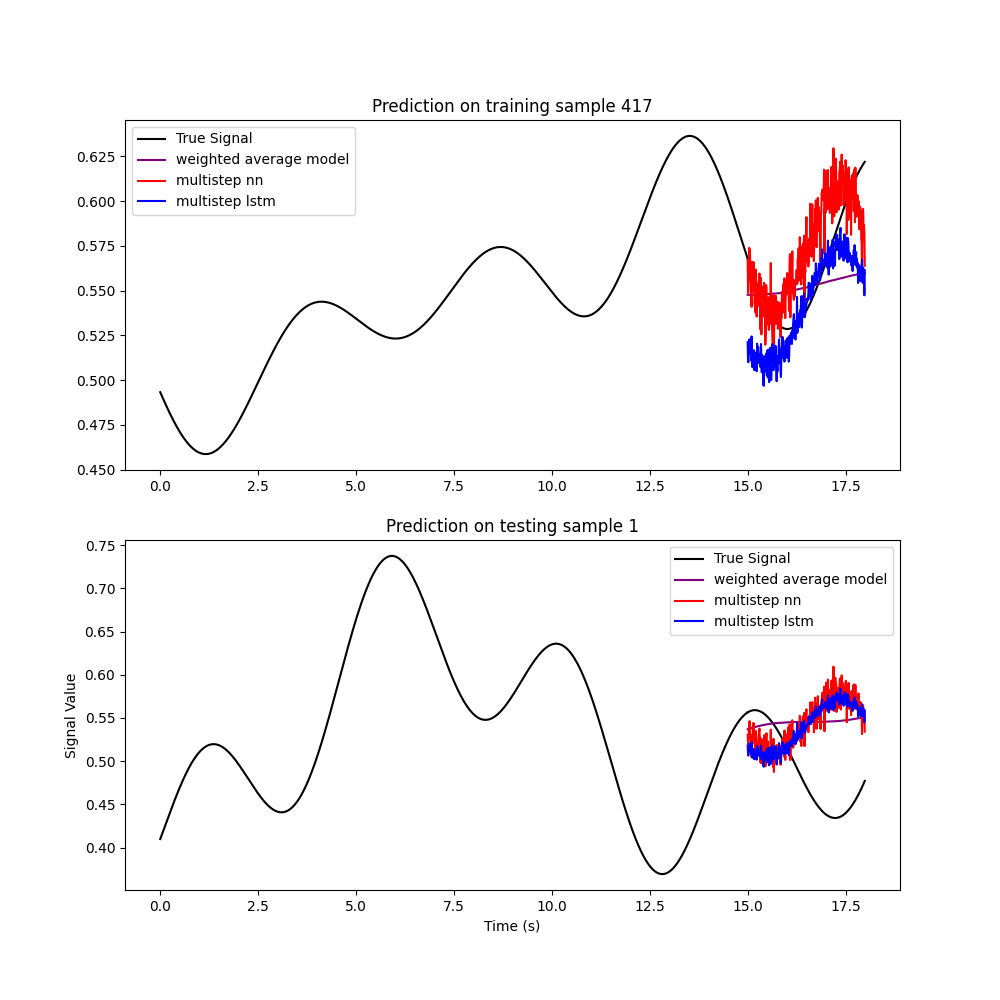

In [13]:
# Predict on random sample in the training set
trainingSample = np.random.randint(0,xTr.shape[0])
testingSample = np.random.randint(0,xTe.shape[0])

model_train_preds_weighted = recursive_predict(model=weighted_average_model, input_data=xTr[[trainingSample]], nRecursive_predictions=forecast)
model_test_preds_weighted = recursive_predict(model=weighted_average_model, input_data=xTe[[testingSample]], nRecursive_predictions=forecast)

model_train_preds_lstm = recursive_predict(model=lstm_model, input_data=xTr[[trainingSample]], nRecursive_predictions=forecast)
model_test_preds_lstm = recursive_predict(model=lstm_model, input_data=xTe[[testingSample]], nRecursive_predictions=forecast)

# model_train_preds_lstm_recursive = recursive_predict(model=lstm_model_recursive_train, input_data=xTr[[trainingSample]], nRecursive_predictions=1)
# model_test_preds_lstm_recursive = recursive_predict(model=lstm_model_recursive_train, input_data=xTe[[testingSample]], nRecursive_predictions=1)

model_train_preds_lstm_multistep = recursive_predict(model=lstm_multistep, input_data=xTr[[trainingSample]], nRecursive_predictions=1)
model_test_preds_lstm_multistep = recursive_predict(model=lstm_multistep, input_data=xTe[[testingSample]], nRecursive_predictions=1)

model_train_preds_multistep_nn = recursive_predict(model=multistepNN, input_data=xTr[[trainingSample]], nRecursive_predictions=1)
model_test_preds_multistep_nn = recursive_predict(model=multistepNN, input_data=xTe[[testingSample]], nRecursive_predictions=1)


plt.figure(figsize=(10, 10))

#Training plot ---
plt.subplot(2,1,1)
#plotting true data
plt.plot(np.arange(lookback) * delta_t, xTr[trainingSample], label='True Signal', color='black')
plt.plot(np.arange(lookback,timesteps) * delta_t, yTr[trainingSample], color='black', label='')

# Plotting model predictions
#weighted average model
plt.plot(np.arange(lookback,timesteps) * delta_t, model_train_preds_weighted[0], color='purple', label='weighted average model')

#recursive predictor lstm
# plt.plot(np.arange(lookback,timesteps) * delta_t, model_train_preds_lstm[0], color='red', label='recursive lstm')

#multistep nn
plt.plot(np.arange(lookback,timesteps) * delta_t, model_train_preds_multistep_nn[0], color='red', label='multistep nn')

#multistep predictor lstm
plt.plot(np.arange(lookback,timesteps) * delta_t, model_train_preds_lstm_multistep[0], color='blue', label='multistep lstm')

plt.title(f"Prediction on training sample {trainingSample}")
plt.legend()

#Testing plot ----
plt.subplot(2,1,2)
#plotting true data
plt.plot(np.arange(lookback) * delta_t, xTe[testingSample], label='True Signal', color='black')
plt.plot(np.arange(lookback,timesteps) * delta_t, yTe[testingSample], color='black', label='')

# Plotting model predictions
#weighted average model
plt.plot(np.arange(lookback,timesteps) * delta_t, model_test_preds_weighted[0], color='purple', label='weighted average model')

#recursive predictor lstm
# plt.plot(np.arange(lookback,timesteps) * delta_t, model_test_preds_lstm[0], color='red', label='recursive lstm')

#multistep nn
plt.plot(np.arange(lookback,timesteps) * delta_t, model_test_preds_multistep_nn[0], color='red', label='multistep nn')

#multistep predictor lstm
plt.plot(np.arange(lookback,timesteps) * delta_t, model_test_preds_lstm_multistep[0], color='blue', label='multistep lstm')

plt.xlabel("Time (s)")
plt.ylabel("Signal Value")
plt.title(f"Prediction on testing sample {testingSample}")
plt.legend()
plt.show()

**Loss over training and testing sets**

In [14]:
weighted_avg_train_preds = recursive_predict(model=weighted_average_model, input_data=xTr, nRecursive_predictions=forecast)
weighted_avg_test_preds = recursive_predict(model=weighted_average_model, input_data=xTe, nRecursive_predictions=forecast)

lstm_multistep_train_preds = recursive_predict(model=lstm_multistep, input_data=xTr, nRecursive_predictions=1)
lstm_multistep_test_preds = recursive_predict(model=lstm_multistep, input_data=xTe, nRecursive_predictions=1)

multistep_nn_train_preds = recursive_predict(model=multistepNN, input_data=xTr, nRecursive_predictions=1)
multistep_nn_test_preds = recursive_predict(model=multistepNN, input_data=xTe, nRecursive_predictions=1)



print(f'weighted average training loss is {calculate_mse_loss(weighted_avg_train_preds,yTr)}')
print(f'multistep LSTM training loss is {calculate_mse_loss(lstm_multistep_train_preds,yTr)}')
print(f'multistep NN training loss is {calculate_mse_loss(multistep_nn_train_preds,yTr)} \n')


print(f'weighted average test loss is {calculate_mse_loss(weighted_avg_test_preds,yTe)}')
print(f'multistep LSTM test loss is {calculate_mse_loss(lstm_multistep_test_preds,yTe)}')
print(f'multistep NN test loss is {calculate_mse_loss(multistep_nn_test_preds,yTe)}')


weighted average training loss is 0.012523883022367954
multistep LSTM training loss is 0.010343261063098907
multistep NN training loss is 0.01190896611660719 

weighted average test loss is 0.013288326561450958
multistep LSTM test loss is 0.011131510138511658
multistep NN test loss is 0.013284202665090561


TODO:
augment the fully connected network with the last few points (64 lstm units + 100 xTr points)
debug with chat bot
plot histograms of activation values
visualize 4*64 weights - inspect forget weight values